<!-- Projeto desenvolvido por Fran Mateus - www.franmateus.com -->
# <font color='darkblue'>MODELOS DE CREDIT SCORING - v2</font>

### **<font color='red'>1- ENTENDIMENTO DO NEGÓCIO</font>**

### **<font color='orange'>Objetivo do projeto:</font>**

Avaliar qual modelo de machine learning, dentre os seis abaixo, apresenta a melhor acurária na **classificação de risco** para concessão de novos créditos a partir de uma determinada base de clientes, usando as métricas de Acurácia, F1 Score e o Teste KS como referência. Além disso, foi feita uma otimização usando o Randomized Search. 

### **<font color='orange'>Algoritmos usados:</font>**

Nesta etapa, estamos usando os algoritmos que apresentaram os melhores resultados na versão 1 dos modelos:
- Gradient Boosting
- LightGBM
- CatBoost

In [ ]:
Otimizador:
    - RandomizedSearchCV

### **<font color='orange'>Base de dados:</font>**

O dataset utilizado chama-se **Default od Credit Cards** e foi disponibilizado pela UCI. Ele possui 1 coluna de identificação, 23 variáveis explicativas, 1 variável dependente binária e 30.000 observações (sem valores ausentes).

*Link para o dataset:* https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

### **<font color='red'>2- COLETA E EXPLORAÇÃO DOS DADOS</font>**

### **<font color='orange'>Bibliotecas/Frameworks:</font>**

In [1]:
# pip install ucimlrepo

In [2]:
# Coleta dos dados
from ucimlrepo import fetch_ucirepo

# Análise exploratória e tratamento dos dados
import pandas as pd
import numpy as np
import math

# Visualização dos dados
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

# Modelagem dos dados
import sklearn as sk
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Avaliação dos modelos
#from sklearn import metrics
from sklearn.metrics import accuracy_score, auc, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, average_precision_score, log_loss, brier_score_loss
from scipy.stats import ks_2samp

import warnings
warnings.filterwarnings("ignore")

C:\Users\mfran\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mfran\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\mfran\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### **<font color='orange'>Leitura do dataset:</font>**

In [3]:
# Coletando os dados 
default_of_credit_card_clients = fetch_ucirepo(id=350) 
  
# Transformando num dataframe 
X = default_of_credit_card_clients.data.features 
y = default_of_credit_card_clients.data.targets

### **<font color='orange'>Exploração dos dados:</font>**

In [4]:
X.shape

(30000, 23)

In [5]:
X.tail(2)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
29998,80000,1,3,1,41,1,-1,0,0,0,...,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804
29999,50000,1,2,1,46,0,0,0,0,0,...,49764,36535,32428,15313,2078,1800,1430,1000,1000,1000


In [6]:
y.shape

(30000, 1)

In [7]:
y.value_counts()

Y
0    23364
1     6636
dtype: int64

### **<font color='darkblue'>3- PREPARAÇÃO DOS DADOS</font>**

### **<font color='red'>Separando as bases em treino e teste:</font>**

In [8]:
# Bases para treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 10)

In [9]:
print("Bases de treino = ", X_train.shape, y_train.shape)

Bases de treino =  (21000, 23) (21000, 1)


In [10]:
print("Bases de teste = ", X_test.shape, y_test.shape)

Bases de teste =  (9000, 23) (9000, 1)


### **<font color='red'>Criando uma função para cálculo das métricas KS e ROC-AUC:</font>**

In [11]:
def ks_and_roc_auc(y_realizado, y_probabilidade):
    df = pd.DataFrame()
    df['realizado'] = y_realizado
    df['probabilidade'] = y_probabilidade[:, 1]
    
    class0 = df[df['realizado'] == 0]
    class1 = df[df['realizado'] == 1]
    
    ks = ks_2samp(class0['probabilidade'], class1['probabilidade'])
    roc_auc = roc_auc_score(df['realizado'] , df['probabilidade'])
    
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.4e})")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    return ks.statistic, roc_auc

### **<font color='darkblue'>4- CRIAÇÃO E AVALIAÇÃO DOS MODELOS DE CLASSIFICAÇÃO</font>**

Esta versão de cada modelo será criada usando os hiperparâmetros pré-definidos pelos algoritmos em seus frameworks.

### **<font color='orangered'>Modelo 1: GradientBoosting</font>**

In [12]:
from time import time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [13]:
# Parâmetros a serem testados
param_dist_gb = {"n_estimators": [20, 30, 40, 100],
                 "learning_rate": [0.001, 0.1, 0.01, 0.5, 1.0]}

# Combinando parâmetros
rs_gb = RandomizedSearchCV(GradientBoostingClassifier(), 
                           param_distributions = param_dist_gb, 
                           n_iter = 20, 
                           return_train_score = True)  
rs_gb.fit(X_train, y_train)

# Melhor estimador
bestrsgb = rs_gb.best_estimator_

print (bestrsgb)

GradientBoostingClassifier(n_estimators=40)


In [14]:
print("Acurácia em treino = ", rs_gb.score(X_train, y_train))

Acurácia em treino =  0.8247142857142857


In [15]:
# Predição
gboost_pred = bestrsgb.predict(X_test)

# Probabilidades
gb_probabilities = bestrsgb.predict_proba(X_test)

# Resultados
print("Resultados:")
print("Acurácia = ", accuracy_score(y_test, gboost_pred))
print("F1 Score= ", f1_score(y_test, gboost_pred))
ks_outcome, auc_outcome = ks_and_roc_auc(y_test, gb_probabilities)

Resultados:
Acurácia =  0.8214444444444444
F1 Score=  0.472941948179731
KS: 0.4360 (p-value: 6.7455e-269)
ROC-AUC: 0.7844


<Axes: >

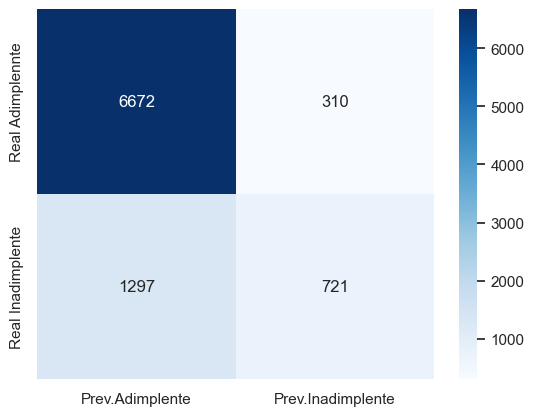

In [16]:
cm6 = confusion_matrix(y_test, gboost_pred)
cmatrix6 = pd.DataFrame(data = cm6, columns=['Prev.Adimplente', 'Prev.Inadimplente'], index=['Real Adimplennte', 'Real Inadimplente'])
sns.heatmap(cmatrix6, annot=True, fmt='d', cmap='Blues')

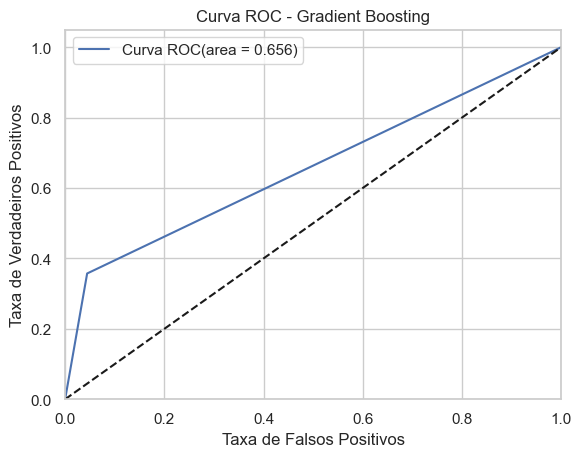

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, gboost_pred) 
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='Curva ROC(area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Gradient Boosting')
plt.legend()
plt.show()

### **<font color='orangered'>Modelo 7: LightGBM</font>**

In [18]:
# Parâmetros a serem testados
param_dist_gb = {"n_estimators": [20, 30, 40, 100],
                 "learning_rate": [0.001, 0.1, 0.01, 0.5, 1.0]}

# Combinando parâmetros
lboost = RandomizedSearchCV(LGBMClassifier(), 
                           param_distributions = param_dist_gb, 
                           n_iter = 20, 
                           return_train_score = True)  
lboost.fit(X_train, y_train)

# Melhor estimador
best_light = lboost.best_estimator_

print (best_light)

LGBMClassifier(n_estimators=40)


In [19]:
print("Acurácia em treino = ", lboost.score(X_train, y_train))

Acurácia em treino =  0.8309047619047619


In [20]:
# Predição
lboost_pred = best_light.predict(X_test)

# Probabilidades
lg_probabilities = lboost.predict_proba(X_test)

# Resultados
print("Resultados:")
print("Acurácia = ", accuracy_score(y_test, lboost_pred))
print("F1 Score= ", f1_score(y_test, lboost_pred))
ks_outcome, auc_outcome = ks_and_roc_auc(y_test, lg_probabilities)

Resultados:
Acurácia =  0.8215555555555556
F1 Score=  0.4775536759921926
KS: 0.4348 (p-value: 2.2738e-267)
ROC-AUC: 0.7855


<Axes: >

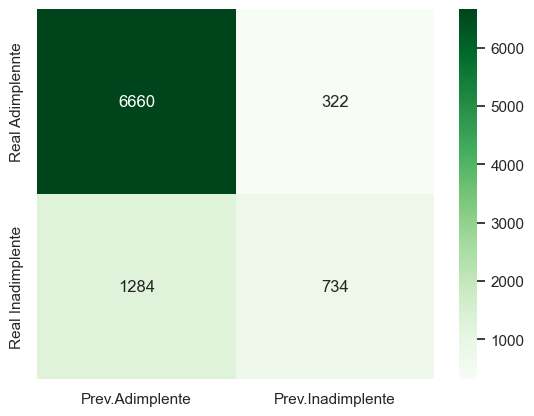

In [21]:
cm7 = confusion_matrix(y_test, lboost_pred)
cmatrix7 = pd.DataFrame(data = cm7, columns=['Prev.Adimplente', 'Prev.Inadimplente'], index=['Real Adimplennte', 'Real Inadimplente'])
sns.heatmap(cmatrix7, annot=True, fmt='d', cmap='Greens')

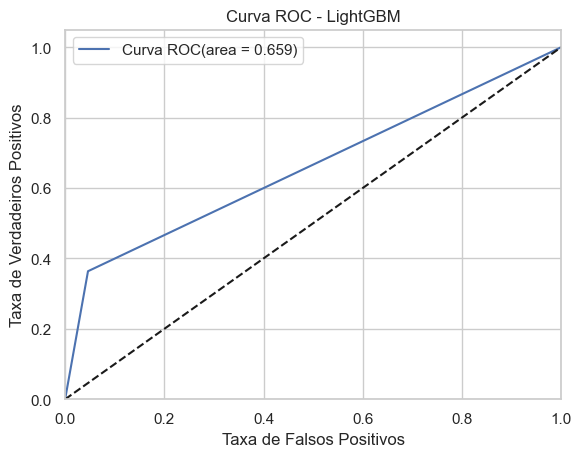

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, lboost_pred) 
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='Curva ROC(area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - LightGBM')
plt.legend()
plt.show()

### **<font color='orangered'>Modelo 8: CatBoost</font>**

In [23]:
# Parâmetros a serem testados
param_dist_gb = {"n_estimators": [20, 30, 40, 100],
                 "learning_rate": [0.001, 0.1, 0.01, 0.5, 1.0]}

# Combinando parâmetros
cboost = RandomizedSearchCV(CatBoostClassifier(), 
                           param_distributions = param_dist_gb, 
                           n_iter = 20, 
                           return_train_score = True)  
cboost.fit(X_train, y_train)

# Melhor estimador
best_cat = cboost.best_estimator_

print (best_cat)

0:	learn: 0.6925737	total: 184ms	remaining: 3.49s
1:	learn: 0.6919881	total: 190ms	remaining: 1.71s
2:	learn: 0.6913978	total: 196ms	remaining: 1.11s
3:	learn: 0.6908214	total: 203ms	remaining: 810ms
4:	learn: 0.6902686	total: 209ms	remaining: 628ms
5:	learn: 0.6896944	total: 216ms	remaining: 504ms
6:	learn: 0.6891259	total: 222ms	remaining: 413ms
7:	learn: 0.6885672	total: 229ms	remaining: 343ms
8:	learn: 0.6879840	total: 235ms	remaining: 288ms
9:	learn: 0.6874240	total: 242ms	remaining: 242ms
10:	learn: 0.6868753	total: 248ms	remaining: 203ms
11:	learn: 0.6863201	total: 254ms	remaining: 169ms
12:	learn: 0.6857542	total: 261ms	remaining: 140ms
13:	learn: 0.6852023	total: 267ms	remaining: 114ms
14:	learn: 0.6846491	total: 273ms	remaining: 91.1ms
15:	learn: 0.6840856	total: 280ms	remaining: 70ms
16:	learn: 0.6835317	total: 287ms	remaining: 50.6ms
17:	learn: 0.6829821	total: 293ms	remaining: 32.5ms
18:	learn: 0.6824303	total: 299ms	remaining: 15.7ms
19:	learn: 0.6818849	total: 305ms	rema

0:	learn: 0.6925806	total: 6.73ms	remaining: 195ms
1:	learn: 0.6919928	total: 13.8ms	remaining: 193ms
2:	learn: 0.6913973	total: 19.9ms	remaining: 179ms
3:	learn: 0.6908170	total: 26.5ms	remaining: 172ms
4:	learn: 0.6902392	total: 32.6ms	remaining: 163ms
5:	learn: 0.6896575	total: 38.7ms	remaining: 155ms
6:	learn: 0.6890811	total: 45ms	remaining: 148ms
7:	learn: 0.6885125	total: 51.3ms	remaining: 141ms
8:	learn: 0.6879448	total: 56.4ms	remaining: 132ms
9:	learn: 0.6873816	total: 62.5ms	remaining: 125ms
10:	learn: 0.6868172	total: 68.7ms	remaining: 119ms
11:	learn: 0.6862519	total: 75ms	remaining: 112ms
12:	learn: 0.6856966	total: 81.3ms	remaining: 106ms
13:	learn: 0.6851527	total: 87.9ms	remaining: 100ms
14:	learn: 0.6845895	total: 94ms	remaining: 94ms
15:	learn: 0.6840289	total: 100ms	remaining: 87.5ms
16:	learn: 0.6834618	total: 106ms	remaining: 81.1ms
17:	learn: 0.6829095	total: 113ms	remaining: 75ms
18:	learn: 0.6823438	total: 119ms	remaining: 68.7ms
19:	learn: 0.6817892	total: 125

5:	learn: 0.6896575	total: 37.7ms	remaining: 214ms
6:	learn: 0.6890811	total: 45ms	remaining: 212ms
7:	learn: 0.6885125	total: 51.5ms	remaining: 206ms
8:	learn: 0.6879448	total: 56.6ms	remaining: 195ms
9:	learn: 0.6873816	total: 63.1ms	remaining: 189ms
10:	learn: 0.6868172	total: 69.4ms	remaining: 183ms
11:	learn: 0.6862519	total: 75.4ms	remaining: 176ms
12:	learn: 0.6856966	total: 81.8ms	remaining: 170ms
13:	learn: 0.6851527	total: 87.8ms	remaining: 163ms
14:	learn: 0.6845895	total: 95ms	remaining: 158ms
15:	learn: 0.6840289	total: 101ms	remaining: 152ms
16:	learn: 0.6834618	total: 108ms	remaining: 146ms
17:	learn: 0.6829095	total: 115ms	remaining: 140ms
18:	learn: 0.6823438	total: 121ms	remaining: 134ms
19:	learn: 0.6817892	total: 127ms	remaining: 127ms
20:	learn: 0.6812668	total: 133ms	remaining: 120ms
21:	learn: 0.6807444	total: 139ms	remaining: 113ms
22:	learn: 0.6801827	total: 145ms	remaining: 107ms
23:	learn: 0.6796219	total: 151ms	remaining: 101ms
24:	learn: 0.6791073	total: 15

46:	learn: 0.6674715	total: 305ms	remaining: 344ms
47:	learn: 0.6669463	total: 312ms	remaining: 338ms
48:	learn: 0.6664317	total: 319ms	remaining: 332ms
49:	learn: 0.6659029	total: 326ms	remaining: 326ms
50:	learn: 0.6653745	total: 332ms	remaining: 319ms
51:	learn: 0.6648563	total: 338ms	remaining: 312ms
52:	learn: 0.6643331	total: 344ms	remaining: 305ms
53:	learn: 0.6638215	total: 350ms	remaining: 299ms
54:	learn: 0.6633126	total: 357ms	remaining: 292ms
55:	learn: 0.6628152	total: 363ms	remaining: 285ms
56:	learn: 0.6623010	total: 369ms	remaining: 279ms
57:	learn: 0.6618058	total: 375ms	remaining: 272ms
58:	learn: 0.6612983	total: 381ms	remaining: 265ms
59:	learn: 0.6607884	total: 388ms	remaining: 258ms
60:	learn: 0.6602798	total: 394ms	remaining: 252ms
61:	learn: 0.6597817	total: 400ms	remaining: 245ms
62:	learn: 0.6592824	total: 406ms	remaining: 238ms
63:	learn: 0.6587776	total: 412ms	remaining: 232ms
64:	learn: 0.6582844	total: 418ms	remaining: 225ms
65:	learn: 0.6577730	total: 425

33:	learn: 0.6742087	total: 222ms	remaining: 431ms
34:	learn: 0.6736846	total: 229ms	remaining: 426ms
35:	learn: 0.6731329	total: 235ms	remaining: 418ms
36:	learn: 0.6726038	total: 242ms	remaining: 412ms
37:	learn: 0.6720587	total: 248ms	remaining: 405ms
38:	learn: 0.6715393	total: 254ms	remaining: 398ms
39:	learn: 0.6710087	total: 261ms	remaining: 391ms
40:	learn: 0.6704815	total: 267ms	remaining: 384ms
41:	learn: 0.6699488	total: 273ms	remaining: 377ms
42:	learn: 0.6694048	total: 279ms	remaining: 370ms
43:	learn: 0.6688661	total: 286ms	remaining: 364ms
44:	learn: 0.6683435	total: 292ms	remaining: 357ms
45:	learn: 0.6678307	total: 298ms	remaining: 350ms
46:	learn: 0.6673000	total: 304ms	remaining: 343ms
47:	learn: 0.6667967	total: 310ms	remaining: 336ms
48:	learn: 0.6662707	total: 316ms	remaining: 329ms
49:	learn: 0.6657503	total: 323ms	remaining: 323ms
50:	learn: 0.6652345	total: 329ms	remaining: 316ms
51:	learn: 0.6647190	total: 335ms	remaining: 309ms
52:	learn: 0.6642084	total: 341

17:	learn: 0.6829206	total: 113ms	remaining: 513ms
18:	learn: 0.6823565	total: 120ms	remaining: 511ms
19:	learn: 0.6818030	total: 126ms	remaining: 504ms
20:	learn: 0.6812650	total: 132ms	remaining: 498ms
21:	learn: 0.6807503	total: 138ms	remaining: 490ms
22:	learn: 0.6801868	total: 144ms	remaining: 483ms
23:	learn: 0.6796548	total: 151ms	remaining: 477ms
24:	learn: 0.6791129	total: 157ms	remaining: 470ms
25:	learn: 0.6785713	total: 163ms	remaining: 463ms
26:	learn: 0.6780453	total: 169ms	remaining: 457ms
27:	learn: 0.6775108	total: 175ms	remaining: 450ms
28:	learn: 0.6769723	total: 182ms	remaining: 445ms
29:	learn: 0.6764289	total: 188ms	remaining: 438ms
30:	learn: 0.6758781	total: 194ms	remaining: 432ms
31:	learn: 0.6753371	total: 200ms	remaining: 426ms
32:	learn: 0.6747912	total: 206ms	remaining: 419ms
33:	learn: 0.6742516	total: 213ms	remaining: 413ms
34:	learn: 0.6737534	total: 217ms	remaining: 402ms
35:	learn: 0.6732364	total: 223ms	remaining: 396ms
36:	learn: 0.6726912	total: 229

5:	learn: 0.4992263	total: 38.5ms	remaining: 89.8ms
6:	learn: 0.4854647	total: 46ms	remaining: 85.5ms
7:	learn: 0.4747058	total: 52.6ms	remaining: 78.9ms
8:	learn: 0.4659496	total: 58.7ms	remaining: 71.7ms
9:	learn: 0.4588864	total: 65.6ms	remaining: 65.6ms
10:	learn: 0.4530577	total: 71.9ms	remaining: 58.8ms
11:	learn: 0.4484563	total: 78.4ms	remaining: 52.3ms
12:	learn: 0.4443826	total: 84.6ms	remaining: 45.6ms
13:	learn: 0.4405454	total: 91ms	remaining: 39ms
14:	learn: 0.4385632	total: 97.8ms	remaining: 32.6ms
15:	learn: 0.4365130	total: 104ms	remaining: 26ms
16:	learn: 0.4342333	total: 110ms	remaining: 19.5ms
17:	learn: 0.4322550	total: 117ms	remaining: 13ms
18:	learn: 0.4307731	total: 123ms	remaining: 6.46ms
19:	learn: 0.4297837	total: 129ms	remaining: 0us
0:	learn: 0.6395950	total: 6.64ms	remaining: 193ms
1:	learn: 0.5963264	total: 12.8ms	remaining: 179ms
2:	learn: 0.5633584	total: 19.4ms	remaining: 174ms
3:	learn: 0.5397707	total: 25.6ms	remaining: 166ms
4:	learn: 0.5191350	tota

0:	learn: 0.6395950	total: 6.71ms	remaining: 262ms
1:	learn: 0.5963264	total: 13.1ms	remaining: 248ms
2:	learn: 0.5633584	total: 19.7ms	remaining: 242ms
3:	learn: 0.5397707	total: 25.8ms	remaining: 232ms
4:	learn: 0.5191350	total: 31.9ms	remaining: 223ms
5:	learn: 0.5014387	total: 38.5ms	remaining: 218ms
6:	learn: 0.4877393	total: 44.7ms	remaining: 211ms
7:	learn: 0.4766992	total: 51.2ms	remaining: 205ms
8:	learn: 0.4679061	total: 57.2ms	remaining: 197ms
9:	learn: 0.4607675	total: 63.3ms	remaining: 190ms
10:	learn: 0.4549156	total: 69.7ms	remaining: 184ms
11:	learn: 0.4503684	total: 76ms	remaining: 177ms
12:	learn: 0.4465869	total: 82.3ms	remaining: 171ms
13:	learn: 0.4428010	total: 88.7ms	remaining: 165ms
14:	learn: 0.4407880	total: 95.3ms	remaining: 159ms
15:	learn: 0.4389291	total: 102ms	remaining: 152ms
16:	learn: 0.4363558	total: 108ms	remaining: 146ms
17:	learn: 0.4345655	total: 115ms	remaining: 140ms
18:	learn: 0.4333263	total: 121ms	remaining: 133ms
19:	learn: 0.4318937	total: 

6:	learn: 0.4854647	total: 44.2ms	remaining: 209ms
7:	learn: 0.4747058	total: 51.8ms	remaining: 207ms
8:	learn: 0.4659496	total: 57.9ms	remaining: 199ms
9:	learn: 0.4588864	total: 65ms	remaining: 195ms
10:	learn: 0.4530577	total: 72.1ms	remaining: 190ms
11:	learn: 0.4484563	total: 78.5ms	remaining: 183ms
12:	learn: 0.4443826	total: 84.9ms	remaining: 176ms
13:	learn: 0.4405454	total: 91.2ms	remaining: 169ms
14:	learn: 0.4385632	total: 97.8ms	remaining: 163ms
15:	learn: 0.4365130	total: 104ms	remaining: 156ms
16:	learn: 0.4342333	total: 110ms	remaining: 149ms
17:	learn: 0.4322550	total: 117ms	remaining: 143ms
18:	learn: 0.4307731	total: 124ms	remaining: 137ms
19:	learn: 0.4297837	total: 130ms	remaining: 130ms
20:	learn: 0.4286177	total: 136ms	remaining: 123ms
21:	learn: 0.4273990	total: 143ms	remaining: 117ms
22:	learn: 0.4262870	total: 149ms	remaining: 110ms
23:	learn: 0.4253097	total: 156ms	remaining: 104ms
24:	learn: 0.4248134	total: 162ms	remaining: 97.1ms
25:	learn: 0.4241226	total:

47:	learn: 0.4158652	total: 310ms	remaining: 336ms
48:	learn: 0.4154556	total: 317ms	remaining: 330ms
49:	learn: 0.4150580	total: 324ms	remaining: 324ms
50:	learn: 0.4145459	total: 330ms	remaining: 318ms
51:	learn: 0.4142173	total: 337ms	remaining: 311ms
52:	learn: 0.4136060	total: 343ms	remaining: 305ms
53:	learn: 0.4130455	total: 350ms	remaining: 298ms
54:	learn: 0.4127643	total: 356ms	remaining: 292ms
55:	learn: 0.4124761	total: 363ms	remaining: 285ms
56:	learn: 0.4121223	total: 369ms	remaining: 279ms
57:	learn: 0.4117124	total: 376ms	remaining: 272ms
58:	learn: 0.4112688	total: 382ms	remaining: 266ms
59:	learn: 0.4109786	total: 388ms	remaining: 259ms
60:	learn: 0.4107292	total: 395ms	remaining: 252ms
61:	learn: 0.4104002	total: 401ms	remaining: 246ms
62:	learn: 0.4100880	total: 407ms	remaining: 239ms
63:	learn: 0.4098421	total: 414ms	remaining: 233ms
64:	learn: 0.4094731	total: 421ms	remaining: 226ms
65:	learn: 0.4092512	total: 427ms	remaining: 220ms
66:	learn: 0.4088020	total: 433

30:	learn: 0.4235462	total: 200ms	remaining: 445ms
31:	learn: 0.4230021	total: 207ms	remaining: 440ms
32:	learn: 0.4225709	total: 214ms	remaining: 434ms
33:	learn: 0.4221312	total: 220ms	remaining: 428ms
34:	learn: 0.4217227	total: 226ms	remaining: 421ms
35:	learn: 0.4212835	total: 233ms	remaining: 414ms
36:	learn: 0.4209188	total: 239ms	remaining: 407ms
37:	learn: 0.4205413	total: 246ms	remaining: 401ms
38:	learn: 0.4200585	total: 252ms	remaining: 394ms
39:	learn: 0.4195604	total: 259ms	remaining: 388ms
40:	learn: 0.4191564	total: 265ms	remaining: 381ms
41:	learn: 0.4188133	total: 271ms	remaining: 374ms
42:	learn: 0.4184732	total: 278ms	remaining: 368ms
43:	learn: 0.4180958	total: 284ms	remaining: 361ms
44:	learn: 0.4178726	total: 290ms	remaining: 354ms
45:	learn: 0.4175371	total: 297ms	remaining: 348ms
46:	learn: 0.4172902	total: 303ms	remaining: 341ms
47:	learn: 0.4169052	total: 309ms	remaining: 335ms
48:	learn: 0.4164395	total: 316ms	remaining: 328ms
49:	learn: 0.4160113	total: 322

12:	learn: 0.6281661	total: 84ms	remaining: 45.2ms
13:	learn: 0.6239619	total: 91.4ms	remaining: 39.2ms
14:	learn: 0.6198333	total: 97.9ms	remaining: 32.6ms
15:	learn: 0.6156995	total: 104ms	remaining: 26.1ms
16:	learn: 0.6116488	total: 110ms	remaining: 19.5ms
17:	learn: 0.6077836	total: 117ms	remaining: 13ms
18:	learn: 0.6039661	total: 123ms	remaining: 6.46ms
19:	learn: 0.6002909	total: 129ms	remaining: 0us
0:	learn: 0.6874146	total: 6.49ms	remaining: 123ms
1:	learn: 0.6816964	total: 13ms	remaining: 117ms
2:	learn: 0.6760576	total: 19.1ms	remaining: 108ms
3:	learn: 0.6709914	total: 23ms	remaining: 92.2ms
4:	learn: 0.6657015	total: 29.3ms	remaining: 87.8ms
5:	learn: 0.6606856	total: 35.4ms	remaining: 82.6ms
6:	learn: 0.6556487	total: 41.7ms	remaining: 77.4ms
7:	learn: 0.6506961	total: 47.8ms	remaining: 71.7ms
8:	learn: 0.6459294	total: 53.9ms	remaining: 65.9ms
9:	learn: 0.6412100	total: 60.2ms	remaining: 60.2ms
10:	learn: 0.6365618	total: 66.5ms	remaining: 54.4ms
11:	learn: 0.6321917	t

0:	learn: 0.6874492	total: 6.55ms	remaining: 190ms
1:	learn: 0.6817831	total: 13.4ms	remaining: 188ms
2:	learn: 0.6763704	total: 19.5ms	remaining: 176ms
3:	learn: 0.6709660	total: 25.8ms	remaining: 168ms
4:	learn: 0.6657251	total: 31.9ms	remaining: 159ms
5:	learn: 0.6605614	total: 38ms	remaining: 152ms
6:	learn: 0.6554894	total: 44.5ms	remaining: 146ms
7:	learn: 0.6505972	total: 50.7ms	remaining: 139ms
8:	learn: 0.6458857	total: 55.9ms	remaining: 130ms
9:	learn: 0.6413038	total: 62ms	remaining: 124ms
10:	learn: 0.6368445	total: 68.3ms	remaining: 118ms
11:	learn: 0.6325172	total: 74.9ms	remaining: 112ms
12:	learn: 0.6282284	total: 81.2ms	remaining: 106ms
13:	learn: 0.6241297	total: 88.1ms	remaining: 101ms
14:	learn: 0.6199847	total: 94.2ms	remaining: 94.2ms
15:	learn: 0.6159395	total: 100ms	remaining: 87.7ms
16:	learn: 0.6119148	total: 106ms	remaining: 81.2ms
17:	learn: 0.6080748	total: 112ms	remaining: 74.8ms
18:	learn: 0.6042143	total: 119ms	remaining: 68.6ms
19:	learn: 0.6005077	tota

35:	learn: 0.5500007	total: 225ms	remaining: 25ms
36:	learn: 0.5473683	total: 232ms	remaining: 18.8ms
37:	learn: 0.5447976	total: 238ms	remaining: 12.5ms
38:	learn: 0.5424135	total: 245ms	remaining: 6.28ms
39:	learn: 0.5399784	total: 252ms	remaining: 0us
0:	learn: 0.6874492	total: 6.46ms	remaining: 252ms
1:	learn: 0.6817831	total: 12.7ms	remaining: 241ms
2:	learn: 0.6763704	total: 19.3ms	remaining: 238ms
3:	learn: 0.6709660	total: 25.4ms	remaining: 229ms
4:	learn: 0.6657251	total: 31.6ms	remaining: 221ms
5:	learn: 0.6605614	total: 37.9ms	remaining: 215ms
6:	learn: 0.6554894	total: 44.2ms	remaining: 208ms
7:	learn: 0.6505972	total: 50.5ms	remaining: 202ms
8:	learn: 0.6458857	total: 55.8ms	remaining: 192ms
9:	learn: 0.6413038	total: 61.7ms	remaining: 185ms
10:	learn: 0.6368445	total: 68ms	remaining: 179ms
11:	learn: 0.6325172	total: 73.9ms	remaining: 173ms
12:	learn: 0.6282284	total: 80.2ms	remaining: 167ms
13:	learn: 0.6241297	total: 86.4ms	remaining: 160ms
14:	learn: 0.6199847	total: 9

94:	learn: 0.4657648	total: 614ms	remaining: 32.3ms
95:	learn: 0.4650959	total: 621ms	remaining: 25.9ms
96:	learn: 0.4643804	total: 628ms	remaining: 19.4ms
97:	learn: 0.4637907	total: 634ms	remaining: 12.9ms
98:	learn: 0.4632090	total: 641ms	remaining: 6.47ms
99:	learn: 0.4624705	total: 647ms	remaining: 0us
0:	learn: 0.6874146	total: 6.82ms	remaining: 675ms
1:	learn: 0.6816964	total: 13.1ms	remaining: 641ms
2:	learn: 0.6760576	total: 19.8ms	remaining: 640ms
3:	learn: 0.6709914	total: 24.1ms	remaining: 577ms
4:	learn: 0.6657015	total: 30.6ms	remaining: 581ms
5:	learn: 0.6606856	total: 36.8ms	remaining: 577ms
6:	learn: 0.6556487	total: 42.9ms	remaining: 571ms
7:	learn: 0.6506961	total: 49.2ms	remaining: 566ms
8:	learn: 0.6459294	total: 55.4ms	remaining: 560ms
9:	learn: 0.6412100	total: 61.6ms	remaining: 554ms
10:	learn: 0.6365618	total: 68.1ms	remaining: 551ms
11:	learn: 0.6321917	total: 74.2ms	remaining: 544ms
12:	learn: 0.6277050	total: 80.4ms	remaining: 538ms
13:	learn: 0.6236373	tota

74:	learn: 0.4819266	total: 484ms	remaining: 161ms
75:	learn: 0.4808586	total: 491ms	remaining: 155ms
76:	learn: 0.4798135	total: 499ms	remaining: 149ms
77:	learn: 0.4787510	total: 505ms	remaining: 143ms
78:	learn: 0.4776486	total: 512ms	remaining: 136ms
79:	learn: 0.4766233	total: 518ms	remaining: 130ms
80:	learn: 0.4756886	total: 525ms	remaining: 123ms
81:	learn: 0.4747123	total: 532ms	remaining: 117ms
82:	learn: 0.4737643	total: 538ms	remaining: 110ms
83:	learn: 0.4728847	total: 544ms	remaining: 104ms
84:	learn: 0.4719241	total: 551ms	remaining: 97.1ms
85:	learn: 0.4710876	total: 557ms	remaining: 90.6ms
86:	learn: 0.4701874	total: 563ms	remaining: 84.2ms
87:	learn: 0.4693189	total: 569ms	remaining: 77.6ms
88:	learn: 0.4685628	total: 575ms	remaining: 71.1ms
89:	learn: 0.4677839	total: 581ms	remaining: 64.6ms
90:	learn: 0.4669421	total: 588ms	remaining: 58.1ms
91:	learn: 0.4661653	total: 594ms	remaining: 51.7ms
92:	learn: 0.4654144	total: 601ms	remaining: 45.2ms
93:	learn: 0.4646352	t

52:	learn: 0.5138252	total: 331ms	remaining: 294ms
53:	learn: 0.5120751	total: 339ms	remaining: 288ms
54:	learn: 0.5103534	total: 345ms	remaining: 282ms
55:	learn: 0.5087344	total: 353ms	remaining: 277ms
56:	learn: 0.5070189	total: 359ms	remaining: 271ms
57:	learn: 0.5055084	total: 366ms	remaining: 265ms
58:	learn: 0.5039336	total: 372ms	remaining: 258ms
59:	learn: 0.5023031	total: 378ms	remaining: 252ms
60:	learn: 0.5008488	total: 384ms	remaining: 246ms
61:	learn: 0.4994330	total: 391ms	remaining: 239ms
62:	learn: 0.4979458	total: 397ms	remaining: 233ms
63:	learn: 0.4965093	total: 403ms	remaining: 227ms
64:	learn: 0.4951095	total: 409ms	remaining: 220ms
65:	learn: 0.4936730	total: 415ms	remaining: 214ms
66:	learn: 0.4922778	total: 422ms	remaining: 208ms
67:	learn: 0.4909664	total: 428ms	remaining: 201ms
68:	learn: 0.4896115	total: 434ms	remaining: 195ms
69:	learn: 0.4883104	total: 440ms	remaining: 189ms
70:	learn: 0.4870794	total: 446ms	remaining: 182ms
71:	learn: 0.4858311	total: 453

3:	learn: 0.4312943	total: 25.3ms	remaining: 164ms
4:	learn: 0.4278236	total: 32.3ms	remaining: 162ms
5:	learn: 0.4262797	total: 39.4ms	remaining: 158ms
6:	learn: 0.4237094	total: 45.6ms	remaining: 150ms
7:	learn: 0.4218285	total: 51.7ms	remaining: 142ms
8:	learn: 0.4201157	total: 58.1ms	remaining: 136ms
9:	learn: 0.4185609	total: 64.2ms	remaining: 128ms
10:	learn: 0.4173998	total: 70.5ms	remaining: 122ms
11:	learn: 0.4160303	total: 76.8ms	remaining: 115ms
12:	learn: 0.4135002	total: 83.2ms	remaining: 109ms
13:	learn: 0.4120645	total: 89.5ms	remaining: 102ms
14:	learn: 0.4114013	total: 95.9ms	remaining: 95.9ms
15:	learn: 0.4093134	total: 103ms	remaining: 90ms
16:	learn: 0.4080530	total: 109ms	remaining: 83.3ms
17:	learn: 0.4061244	total: 116ms	remaining: 77.1ms
18:	learn: 0.4041983	total: 122ms	remaining: 70.5ms
19:	learn: 0.4030840	total: 128ms	remaining: 64.2ms
20:	learn: 0.4014803	total: 135ms	remaining: 57.6ms
21:	learn: 0.3995339	total: 141ms	remaining: 51.1ms
22:	learn: 0.3980491

28:	learn: 0.3867567	total: 205ms	remaining: 77.6ms
29:	learn: 0.3852134	total: 212ms	remaining: 70.6ms
30:	learn: 0.3836034	total: 219ms	remaining: 63.6ms
31:	learn: 0.3823577	total: 226ms	remaining: 56.4ms
32:	learn: 0.3809487	total: 232ms	remaining: 49.2ms
33:	learn: 0.3792026	total: 238ms	remaining: 42ms
34:	learn: 0.3780567	total: 244ms	remaining: 34.9ms
35:	learn: 0.3764244	total: 251ms	remaining: 27.9ms
36:	learn: 0.3749706	total: 257ms	remaining: 20.8ms
37:	learn: 0.3737554	total: 264ms	remaining: 13.9ms
38:	learn: 0.3723962	total: 270ms	remaining: 6.92ms
39:	learn: 0.3714458	total: 276ms	remaining: 0us
0:	learn: 0.4984258	total: 7.22ms	remaining: 282ms
1:	learn: 0.4490993	total: 14.7ms	remaining: 280ms
2:	learn: 0.4343262	total: 21.8ms	remaining: 268ms
3:	learn: 0.4298163	total: 28.4ms	remaining: 256ms
4:	learn: 0.4256125	total: 34.7ms	remaining: 243ms
5:	learn: 0.4218797	total: 40.9ms	remaining: 232ms
6:	learn: 0.4200731	total: 47.1ms	remaining: 222ms
7:	learn: 0.4182333	tota

31:	learn: 0.3848573	total: 203ms	remaining: 432ms
32:	learn: 0.3835833	total: 211ms	remaining: 428ms
33:	learn: 0.3811293	total: 217ms	remaining: 422ms
34:	learn: 0.3794020	total: 224ms	remaining: 416ms
35:	learn: 0.3778803	total: 230ms	remaining: 409ms
36:	learn: 0.3760971	total: 237ms	remaining: 403ms
37:	learn: 0.3746628	total: 243ms	remaining: 396ms
38:	learn: 0.3734976	total: 249ms	remaining: 390ms
39:	learn: 0.3725444	total: 255ms	remaining: 383ms
40:	learn: 0.3710263	total: 261ms	remaining: 376ms
41:	learn: 0.3697689	total: 268ms	remaining: 370ms
42:	learn: 0.3694740	total: 274ms	remaining: 363ms
43:	learn: 0.3677681	total: 281ms	remaining: 357ms
44:	learn: 0.3656643	total: 287ms	remaining: 351ms
45:	learn: 0.3640800	total: 294ms	remaining: 345ms
46:	learn: 0.3627059	total: 300ms	remaining: 338ms
47:	learn: 0.3612467	total: 306ms	remaining: 332ms
48:	learn: 0.3600170	total: 313ms	remaining: 325ms
49:	learn: 0.3595837	total: 319ms	remaining: 319ms
50:	learn: 0.3582853	total: 325

11:	learn: 0.4126025	total: 77.4ms	remaining: 568ms
12:	learn: 0.4111876	total: 85.1ms	remaining: 569ms
13:	learn: 0.4099143	total: 98.3ms	remaining: 604ms
14:	learn: 0.4086683	total: 108ms	remaining: 610ms
15:	learn: 0.4078465	total: 114ms	remaining: 598ms
16:	learn: 0.4062134	total: 121ms	remaining: 590ms
17:	learn: 0.4047258	total: 127ms	remaining: 578ms
18:	learn: 0.4031785	total: 133ms	remaining: 568ms
19:	learn: 0.4020215	total: 140ms	remaining: 560ms
20:	learn: 0.4007119	total: 146ms	remaining: 550ms
21:	learn: 0.3992436	total: 152ms	remaining: 540ms
22:	learn: 0.3974876	total: 158ms	remaining: 530ms
23:	learn: 0.3961052	total: 165ms	remaining: 521ms
24:	learn: 0.3949086	total: 171ms	remaining: 513ms
25:	learn: 0.3932130	total: 177ms	remaining: 504ms
26:	learn: 0.3911544	total: 184ms	remaining: 497ms
27:	learn: 0.3897134	total: 191ms	remaining: 490ms
28:	learn: 0.3880787	total: 197ms	remaining: 483ms
29:	learn: 0.3877790	total: 204ms	remaining: 476ms
30:	learn: 0.3859489	total: 

91:	learn: 0.3110466	total: 620ms	remaining: 53.9ms
92:	learn: 0.3097967	total: 628ms	remaining: 47.3ms
93:	learn: 0.3085716	total: 636ms	remaining: 40.6ms
94:	learn: 0.3077041	total: 643ms	remaining: 33.8ms
95:	learn: 0.3068029	total: 650ms	remaining: 27.1ms
96:	learn: 0.3057689	total: 658ms	remaining: 20.3ms
97:	learn: 0.3047962	total: 664ms	remaining: 13.6ms
98:	learn: 0.3038181	total: 671ms	remaining: 6.78ms
99:	learn: 0.3031793	total: 678ms	remaining: 0us
0:	learn: 0.4986210	total: 6.59ms	remaining: 653ms
1:	learn: 0.4489289	total: 13ms	remaining: 636ms
2:	learn: 0.4349386	total: 19.1ms	remaining: 616ms
3:	learn: 0.4293890	total: 25.6ms	remaining: 614ms
4:	learn: 0.4247463	total: 31.9ms	remaining: 606ms
5:	learn: 0.4216706	total: 38.1ms	remaining: 597ms
6:	learn: 0.4193653	total: 44.6ms	remaining: 592ms
7:	learn: 0.4176072	total: 50.7ms	remaining: 583ms
8:	learn: 0.4163449	total: 57ms	remaining: 576ms
9:	learn: 0.4154424	total: 62.9ms	remaining: 566ms
10:	learn: 0.4142870	total: 6

16:	learn: 0.3922194	total: 108ms	remaining: 19.1ms
17:	learn: 0.3890315	total: 116ms	remaining: 12.9ms
18:	learn: 0.3866611	total: 122ms	remaining: 6.43ms
19:	learn: 0.3830669	total: 129ms	remaining: 0us
0:	learn: 0.4440955	total: 6.96ms	remaining: 132ms
1:	learn: 0.4360668	total: 13.3ms	remaining: 120ms
2:	learn: 0.4308602	total: 20ms	remaining: 113ms
3:	learn: 0.4263695	total: 26.6ms	remaining: 107ms
4:	learn: 0.4238117	total: 32.8ms	remaining: 98.3ms
5:	learn: 0.4198241	total: 39.1ms	remaining: 91.2ms
6:	learn: 0.4178738	total: 45.4ms	remaining: 84.2ms
7:	learn: 0.4151616	total: 51.7ms	remaining: 77.5ms
8:	learn: 0.4135422	total: 58ms	remaining: 70.8ms
9:	learn: 0.4117115	total: 64.2ms	remaining: 64.2ms
10:	learn: 0.4101614	total: 70.3ms	remaining: 57.5ms
11:	learn: 0.4075022	total: 76.7ms	remaining: 51.2ms
12:	learn: 0.4045323	total: 82.9ms	remaining: 44.6ms
13:	learn: 0.4014845	total: 89.6ms	remaining: 38.4ms
14:	learn: 0.3995796	total: 95.9ms	remaining: 32ms
15:	learn: 0.3973475

0:	learn: 0.4469059	total: 6.76ms	remaining: 196ms
1:	learn: 0.4342818	total: 13.4ms	remaining: 187ms
2:	learn: 0.4276399	total: 19.6ms	remaining: 176ms
3:	learn: 0.4237835	total: 25.9ms	remaining: 168ms
4:	learn: 0.4200943	total: 32.1ms	remaining: 161ms
5:	learn: 0.4168685	total: 38.4ms	remaining: 154ms
6:	learn: 0.4154183	total: 44.6ms	remaining: 147ms
7:	learn: 0.4133758	total: 50.9ms	remaining: 140ms
8:	learn: 0.4105034	total: 57.3ms	remaining: 134ms
9:	learn: 0.4094100	total: 63.6ms	remaining: 127ms
10:	learn: 0.4064103	total: 69.9ms	remaining: 121ms
11:	learn: 0.4041393	total: 76ms	remaining: 114ms
12:	learn: 0.4025820	total: 82.2ms	remaining: 107ms
13:	learn: 0.3995335	total: 88.6ms	remaining: 101ms
14:	learn: 0.3979416	total: 95ms	remaining: 95ms
15:	learn: 0.3959439	total: 101ms	remaining: 88.6ms
16:	learn: 0.3938795	total: 107ms	remaining: 82.1ms
17:	learn: 0.3913244	total: 114ms	remaining: 75.7ms
18:	learn: 0.3885519	total: 120ms	remaining: 69.6ms
19:	learn: 0.3867148	total:

19:	learn: 0.3876207	total: 129ms	remaining: 129ms
20:	learn: 0.3851035	total: 137ms	remaining: 124ms
21:	learn: 0.3827054	total: 143ms	remaining: 117ms
22:	learn: 0.3804105	total: 149ms	remaining: 110ms
23:	learn: 0.3782954	total: 156ms	remaining: 104ms
24:	learn: 0.3762069	total: 162ms	remaining: 97.5ms
25:	learn: 0.3741413	total: 169ms	remaining: 91.1ms
26:	learn: 0.3719840	total: 175ms	remaining: 84.4ms
27:	learn: 0.3698392	total: 182ms	remaining: 77.9ms
28:	learn: 0.3678286	total: 188ms	remaining: 71.4ms
29:	learn: 0.3658636	total: 195ms	remaining: 64.9ms
30:	learn: 0.3635706	total: 201ms	remaining: 58.4ms
31:	learn: 0.3611879	total: 207ms	remaining: 51.8ms
32:	learn: 0.3586026	total: 214ms	remaining: 45.3ms
33:	learn: 0.3563327	total: 221ms	remaining: 38.9ms
34:	learn: 0.3542283	total: 227ms	remaining: 32.4ms
35:	learn: 0.3526811	total: 233ms	remaining: 25.9ms
36:	learn: 0.3512477	total: 240ms	remaining: 19.4ms
37:	learn: 0.3493833	total: 246ms	remaining: 13ms
38:	learn: 0.347688

11:	learn: 0.4070744	total: 77.1ms	remaining: 566ms
12:	learn: 0.4050457	total: 84.4ms	remaining: 565ms
13:	learn: 0.4021332	total: 90.8ms	remaining: 558ms
14:	learn: 0.3993603	total: 98.1ms	remaining: 556ms
15:	learn: 0.3960733	total: 105ms	remaining: 549ms
16:	learn: 0.3933189	total: 111ms	remaining: 543ms
17:	learn: 0.3909169	total: 118ms	remaining: 537ms
18:	learn: 0.3877313	total: 124ms	remaining: 530ms
19:	learn: 0.3851858	total: 131ms	remaining: 523ms
20:	learn: 0.3823274	total: 137ms	remaining: 515ms
21:	learn: 0.3807879	total: 143ms	remaining: 507ms
22:	learn: 0.3777152	total: 149ms	remaining: 500ms
23:	learn: 0.3756283	total: 156ms	remaining: 492ms
24:	learn: 0.3730809	total: 163ms	remaining: 489ms
25:	learn: 0.3710761	total: 170ms	remaining: 484ms
26:	learn: 0.3690192	total: 177ms	remaining: 480ms
27:	learn: 0.3659534	total: 185ms	remaining: 475ms
28:	learn: 0.3646865	total: 191ms	remaining: 468ms
29:	learn: 0.3644472	total: 198ms	remaining: 461ms
30:	learn: 0.3625645	total:

98:	learn: 0.2462420	total: 643ms	remaining: 6.49ms
99:	learn: 0.2449016	total: 650ms	remaining: 0us
0:	learn: 0.4440955	total: 6.59ms	remaining: 652ms
1:	learn: 0.4360668	total: 12.8ms	remaining: 627ms
2:	learn: 0.4308602	total: 19.1ms	remaining: 617ms
3:	learn: 0.4263695	total: 25.4ms	remaining: 609ms
4:	learn: 0.4238117	total: 31.3ms	remaining: 595ms
5:	learn: 0.4198241	total: 37.8ms	remaining: 592ms
6:	learn: 0.4178738	total: 43.9ms	remaining: 584ms
7:	learn: 0.4151616	total: 50.3ms	remaining: 578ms
8:	learn: 0.4135422	total: 56.4ms	remaining: 570ms
9:	learn: 0.4117115	total: 62.5ms	remaining: 563ms
10:	learn: 0.4101614	total: 68.6ms	remaining: 555ms
11:	learn: 0.4075022	total: 74.9ms	remaining: 549ms
12:	learn: 0.4045323	total: 81.2ms	remaining: 544ms
13:	learn: 0.4014845	total: 87.5ms	remaining: 537ms
14:	learn: 0.3995796	total: 93.9ms	remaining: 532ms
15:	learn: 0.3973475	total: 100ms	remaining: 526ms
16:	learn: 0.3938795	total: 107ms	remaining: 520ms
17:	learn: 0.3923802	total:

76:	learn: 0.2804538	total: 503ms	remaining: 150ms
77:	learn: 0.2796835	total: 510ms	remaining: 144ms
78:	learn: 0.2782271	total: 517ms	remaining: 137ms
79:	learn: 0.2772646	total: 523ms	remaining: 131ms
80:	learn: 0.2756268	total: 530ms	remaining: 124ms
81:	learn: 0.2739986	total: 536ms	remaining: 118ms
82:	learn: 0.2724847	total: 542ms	remaining: 111ms
83:	learn: 0.2709046	total: 549ms	remaining: 104ms
84:	learn: 0.2690016	total: 555ms	remaining: 97.9ms
85:	learn: 0.2671879	total: 561ms	remaining: 91.4ms
86:	learn: 0.2654574	total: 568ms	remaining: 84.9ms
87:	learn: 0.2642234	total: 574ms	remaining: 78.3ms
88:	learn: 0.2629517	total: 581ms	remaining: 71.8ms
89:	learn: 0.2616307	total: 587ms	remaining: 65.2ms
90:	learn: 0.2598854	total: 594ms	remaining: 58.7ms
91:	learn: 0.2578149	total: 600ms	remaining: 52.2ms
92:	learn: 0.2564297	total: 606ms	remaining: 45.6ms
93:	learn: 0.2553571	total: 613ms	remaining: 39.1ms
94:	learn: 0.2542074	total: 619ms	remaining: 32.6ms
95:	learn: 0.2526151

In [24]:
print("Acurácia em treino = ", cboost.score(X_train, y_train))

Acurácia em treino =  0.8316666666666667


In [25]:
# Predição
cboost_pred = best_cat.predict(X_test)

# Probabilidades
cat_probabilities = cboost.predict_proba(X_test)

In [26]:
# Resultados
print("Resultados:")
print("Acurácia = ", accuracy_score(y_test, cboost_pred))
print("F1 Score= ", f1_score(y_test, cboost_pred))
ks_outcome, auc_outcome = ks_and_roc_auc(y_test, cat_probabilities)

Resultados:
Acurácia =  0.822
F1 Score=  0.47647058823529403
KS: 0.4456 (p-value: 2.6102e-281)
ROC-AUC: 0.7884


<Axes: >

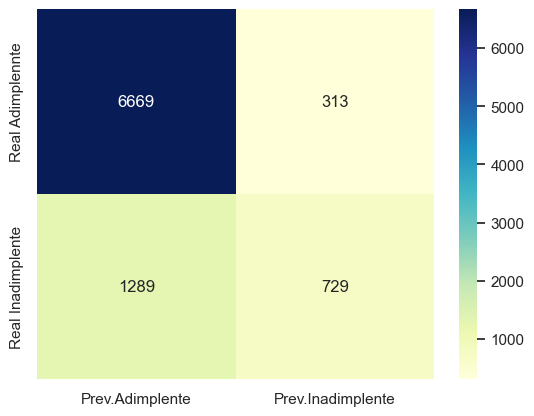

In [27]:
cm8 = confusion_matrix(y_test, cboost_pred)
cmatrix8 = pd.DataFrame(data = cm8, columns=['Prev.Adimplente', 'Prev.Inadimplente'], index=['Real Adimplennte', 'Real Inadimplente'])
sns.heatmap(cmatrix8, annot=True, fmt='d', cmap='YlGnBu')

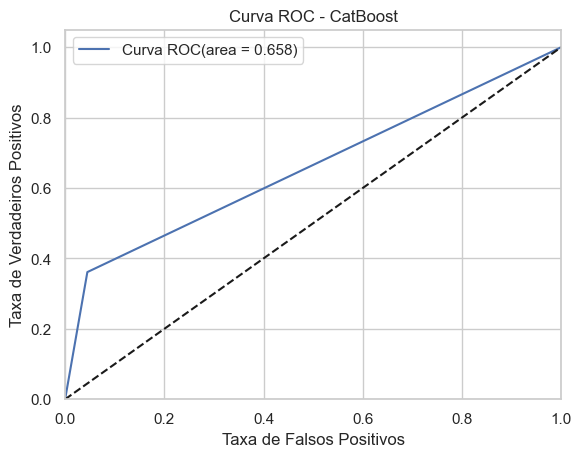

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, cboost_pred) 
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='Curva ROC(area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - CatBoost')
plt.legend()
plt.show()

In [29]:
# Targets
targets_model8 = pd.DataFrame(cboost_pred, columns=['Target_CatBoost'], index=[X_test.index])
targets_model8 = targets_model8.reset_index()

# Probabilidades
result_probas8 = pd.DataFrame(cat_probabilities, columns=['Prob_Adimplencia', 'Prob_Inadimplencia'], index=[X_test.index])
result_probabilities8 = result_probas8.reset_index()

In [30]:
result_probas8['Prob_Inadimplencia'].describe()

count    9000.000000
mean        0.219958
std         0.193796
min         0.015838
25%         0.096759
50%         0.142951
75%         0.255786
max         0.947552
Name: Prob_Inadimplencia, dtype: float64

### **<font color='darkblue'>4 - RANKING DA 2ª VERSÃO DOS MODELOS PARA CLASSIFICAÇÃO DE RISCO DE CRÉDITO</font>**

Fazendo o tuning de apenas 2 hiperparâmetros (n_estimators e learning_rate), os três algortimos apresentaram pequenas melhoras ou pioras em seus resultados, dependendo da métrica observada, conforme abaixo.

Métrica: **Acurácia**
- 1º) LightGBM          = De 0.8223 para <font color='red'>0.8215</font>
- 2º) CatBoost          = De 0.8222 para <font color='red'>0.8220</font>
- 3º) Gradient Boosting = De 0.8202 para <font color='darkblue'>0.8214</font>

Métrica: **F1 Score**
- 1º) CatBoost          = De 0.4835 para <font color='red'>0.4765</font>
- 2º) LightGBM          = De 0.4824 para <font color='red'>0.4776</font>
- 3º) Gradient Boosting = De 0.4726 para <font color='darkblue'>0.4729</font>

Métrica: **Teste KS**
- 1º) Gradient Boosting = De 0.4396 para <font color='red'>0.4360</font>
- 2º) CatBoost          = De 0.4338 para <font color='darkblue'>0.4456</font>
- 3º) LightGBM          = De 0.4282 para <font color='darkblue'>0.4348</font>

Nota: os resultados do Gradient Boosting apresentaram leve melhora em **Acurácia** e **F1 Score**, ao passo que o LightGBM e o CatBoost tiveram um aumento de performance, somente, no **Teste KS**.

### **<font color='darkblue'>5 - PRÓXIMOS PASSOS</font>**

O próximo passo será a execução da mesma base de dados usando modelos de a) redes neurais e de b) redes neurais profundas.